In [1]:
%matplotlib

from GQME_discretization_error.heom import commutator

import os
import numpy as np
import h5py
import copy
from numba import njit
import matplotlib.pyplot as plt

os.environ["OMP_NUM_THREADS"] = "1" 

@njit
def eval_integral(Usd, kappa, imax, dt):
    ret = np.zeros((Usd.shape[1], Usd.shape[2]), dtype=kappa.dtype)
    for i in range(imax):
        ret += (Usd[imax-(i+1)]@kappa[i+1]+Usd[imax-i]@kappa[i])*dt/2.0
        
    return ret

@njit
def compute_kernel(Us, Usd, Usdd, Ls, dt):
    kappa = np.zeros(Us.shape, dtype=np.complex128)
    for i in range(Us.shape[0]):
        kappa[i] = Usdd[i] - Usd[i]@Ls - eval_integral(Usd, kappa, i, dt)
    return kappa

def compute_derivative(Us, dt):
    Usd = np.zeros(Us.shape, dtype=np.complex128)

    for i in range(Us.shape[0]):
        if i == 0:
            Usd[0, :, :] = (-3*Us[0, :, :] + 4*Us[1, :, :]  - Us[2, :, :])/(2*dt)
        elif i+1 == Us.shape[0]:
            Usd[i, :, :] = (Us[i-2, :, :] - 4*Us[i-1, :, :]  +3*Us[i, :, :])/(2*dt)
        elif i == 1 or i+2 == Us.shape[0]:
            Usd[i, :, :] = (Us[i+1, :, :] - Us[i-1, :, :])/(2*dt)
        else:
            Usd[i, :, :] = (-Us[i+2, :, :] + 8*Us[i+1, :, :] - 8*Us[i-1, :, :] + Us[i-2, :, :])/(12*dt)
    return Usd


def compute_second_derivative(Us, dt):
    Usdd = np.zeros(Us.shape, dtype=np.complex128)

    for i in range(Us.shape[0]):
        if i < 1:
            Usdd[i, :, :] = (2*Us[i, :, :] - 5*Us[i+1, :, :] +4*Us[i+2, :, :]-Us[i+3, :, :])/(dt**2)#(Us[i, :, :] - 2*Us[i+1, :, :] + Us[i+2, :, :])/(dt**2)#
        elif i < 2:
            Usdd[i, :, :] = (2*Us[i, :, :] - 5*Us[i+1, :, :] +4*Us[i+2, :, :]-Us[i+3, :, :])/(dt**2)#(Us[i+1, :, :] - 2*Us[i, :, :] + Us[i-1, :, :])/(dt**2)#
        elif i+2 >= Us.shape[0]:
            Usdd[i, :, :] = (2*Us[i, :, :] - 5*Us[i-1, :, :] +4*Us[i-2, :, :]-Us[i-3, :, :])/(dt**2)
        else:
            Usdd[i, :, :] = (-Us[i+2, :, :] + 16*Us[i+1, :, :] - 30*Us[i, :, :] + 16*Us[i-1, :, :] - Us[i-2, :, :])/(12*dt**2)
    return Usdd


def plot_kappa(dt):
    fname = 'propagator_'+str(dt)+'.h5'
    if not fname == None:
        h5 = h5py.File(fname, 'r')
        Us = np.array(h5.get('Us'))
        dUs = np.array(h5.get('dUs'))
        d2Us = np.array(h5.get('d2Us'))

        h5.close()

    for i in range(Us.shape[0]):
        t = copy.deepcopy(Us[i, 1, :])
        Us[i, 1, :] = copy.deepcopy(Us[i, 2, :])
        Us[i, 2, :] = copy.deepcopy(t)
        t = copy.deepcopy(dUs[i, 1, :])
        dUs[i, 1, :] = copy.deepcopy(dUs[i, 2, :])
        dUs[i, 2,] = copy.deepcopy(t)
        t = copy.deepcopy(d2Us[i, 1, :])
        d2Us[i, 1, :] = copy.deepcopy(d2Us[i, 2, :])
        d2Us[i, 2, :] = copy.deepcopy(t)
        
    Usd = compute_derivative(Us, dt)
    Usdd = compute_second_derivative(Us, dt)
    nt = Usd.shape[0]
    nt = (nt//10)*10
    
    Usd = Usd[:nt, :, :]
    Usdd = Usdd[:nt, :, :]
    Us = Us[:nt, :, :]
    dUs = dUs[:nt, :, :]
    d2Us = d2Us[:nt, :, :]

    #fig = plt.figure()
    #plt.semilogy(np.arange(nt)*dt, np.linalg.norm(Usd-dUs,axis=(1,2)), 'k-')

    #fig = plt.figure()
    #plt.semilogy(np.arange(nt)*dt, np.linalg.norm(Usdd-d2Us,axis=(1,2)), 'k-')
    #fig, ax = plt.subplots(4,4)    
    #fig.subplots_adjust(wspace=0, hspace=0)

    #for i in range(4):
    #    for j in range(4):
    #        ax[i,j].plot(np.arange(nt)*dt, np.abs(Usd[:, i, j]-dUs[:, i, j]))
    #        #ax[i,j].plot(np.arange(nt)*dt, np.real(Usd[:, i, j]))
    #        #ax[i,j].plot(np.arange(nt)*dt, np.real(dUs[:, i, j]))


    #fig, ax = plt.subplots(4,4)
    #fig.subplots_adjust(wspace=0, hspace=0)

    #for i in range(4):
    #    for j in range(4):
    #        ax[i,j].plot(np.arange(nt)*dt, np.abs(Usdd[:, i, j]-d2Us[:, i, j]))
    #        #ax[i,j].plot(np.arange(nt)*dt, np.real(Usdd[:, i, j]))
    #        #ax[i,j].plot(np.arange(nt)*dt, np.real(d2Us[:, i, j]))

    eps = 0.0
    delta = -1.0
    sx = np.array([[0, 1], [1, 0]], dtype = np.complex128)
    sz = np.array([[1, 0], [0, -1]], dtype = np.complex128)
    Hs = eps*sz + delta*sx    
    Ls = -1.0j*commutator(Hs)

    kappa = compute_kernel(Us, dUs, d2Us, Ls, dt)
    kappads = compute_kernel(Us, Usd, Usdd, Ls, dt)

    fig, ax = plt.subplots(4,4)
    fig.subplots_adjust(wspace=0, hspace=0)
    for i in range(4):
        for j in range(4):
            ax[i,j].plot((np.arange(kappa.shape[0]-1)+1)*dt, np.real(kappa[1:, i, j]), 'k-')
            ax[i,j].plot((np.arange(kappa.shape[0]-1)+1)*dt, np.imag(kappa[1:, i, j]), 'k-.')
            ax[i,j].plot((np.arange(kappads.shape[0]-1)+1)*dt, np.real(kappads[1:, i, j]), 'r--')
            ax[i,j].plot((np.arange(kappads.shape[0]-1)+1)*dt, np.imag(kappads[1:, i, j]), 'r-.')



    #fig, ax = plt.subplots(4,4)
    #fig.subplots_adjust(wspace=0, hspace=0)

    #fig = plt.figure()
    #titles = ['00', '01', '10', '11']
    #plt.semilogy(np.arange(kappa.shape[0])*dt, np.linalg.norm(kappa-kappads,axis=(1,2)), 'k-')
    #for i in range(4):
    #    for j in range(4):
    #        ax[i,j].plot(np.arange(kappa.shape[0])*dt, np.real(kappa[:, i, j]-kappads[:, i, j]), 'k-')
    #        ax[i,j].plot(np.arange(kappa.shape[0])*dt, np.imag(kappa[:, i, j]-kappads[:, i, j]), 'r-')
    return fig, ax

def compute_kappa(dt):
    fname = 'propagator_'+str(dt)+'.h5'
    if not fname == None:
        h5 = h5py.File(fname, 'r')
        Us = np.array(h5.get('Us'))
        dUs = np.array(h5.get('dUs'))
        d2Us = np.array(h5.get('d2Us'))

        h5.close()

    eps = 0.0
    delta = -1.0
    sx = np.array([[0, 1], [1, 0]], dtype = np.complex128)
    sz = np.array([[1, 0], [0, -1]], dtype = np.complex128)
    Hs = eps*sz + delta*sx
    Ls = -1.0j*commutator(Hs)

    kappa = compute_kernel(Us, dUs, d2Us, Ls, dt)
    return dt*np.arange(kappa.shape[0]), kappa


/home/lachlan/memory_kernel_heom/GQME_discretization_error/.venv/lib/python3.12/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


Using matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
t1a, k1a = compute_kappa(0.01)
print("a")
t1, k1 = compute_kappa(0.005)
print("b")
t2a, k2a = compute_kappa(0.001)
print("c")
t2, k2 = compute_kappa(0.0005)
print("d")
t3a, k3a = compute_kappa(0.0001)
print("e")
t3, k3 = compute_kappa(0.00005)

a
b
c
d
e


In [ ]:
import h5py
ts = [t1a, t1, t2a, t2, t3a, t3]
ks = [k1a, k1, k2a, k2, k3a, k3]
for t, k, dt in zip(ts, ks, [0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]):
    h5out = h5py.File("kappa_"+str(dt)+".h5", 'w')
    h5out.create_dataset('t', data=t)
    h5out.create_dataset('kappa', data=k)
    h5out.close()

(100, 4, 4) (100, 4, 4)


(0.01, 0.51)

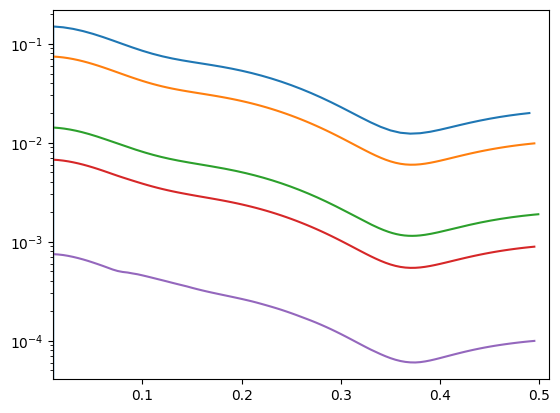

In [3]:
print(k1[:100, :, :].shape, k2[:1000:10,:, :].shape)
plt.semilogy(t1a[:50], np.linalg.norm(k1a[:50, :, :]-k3[:10000:200],axis=(1,2)))
plt.semilogy(t1[:100], np.linalg.norm(k1[:100, :, :]-k3[:10000:100],axis=(1,2)))
plt.semilogy(t2a[:500], np.linalg.norm(k2a[:500, :, :]-k3[:10000:20],axis=(1,2)))
plt.semilogy(t1[:100], np.linalg.norm(k2[:1000:10, :, :]-k3[:10000:100],axis=(1,2)))
plt.semilogy(t1[:100], np.linalg.norm(k3a[:5000:50, :, :]-k3[:10000:100],axis=(1,2)))
plt.xlim(t1[2], t1[-1])

(<Figure size 640x480 with 16 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

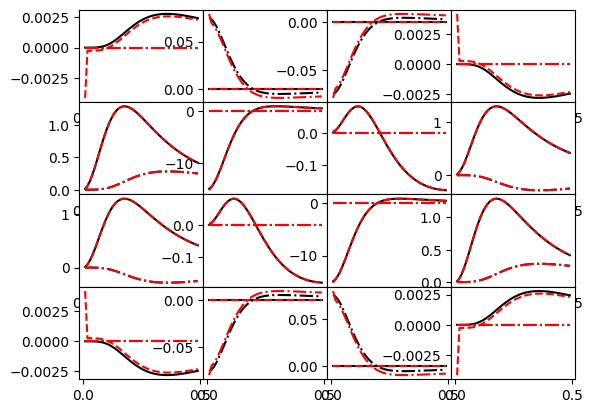

In [4]:
plot_kappa(0.01)

(<Figure size 640x480 with 16 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

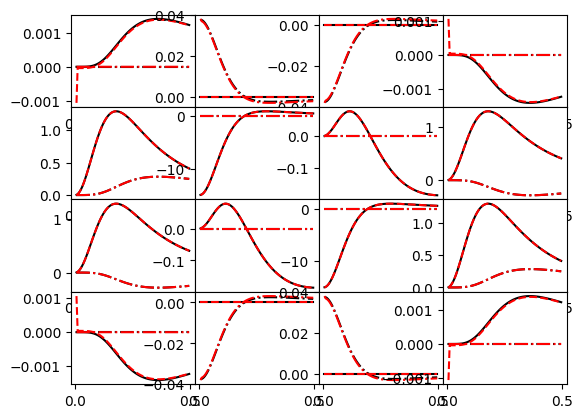

In [5]:
plot_kappa(0.005)


(<Figure size 640x480 with 16 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

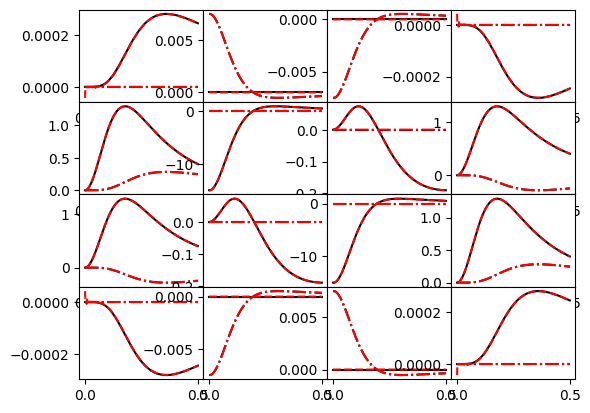

In [6]:
plot_kappa(0.001)


(<Figure size 640x480 with 16 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

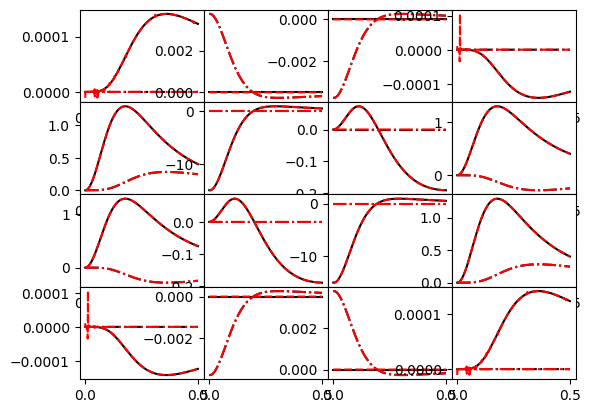

In [7]:
plot_kappa(0.0005)


(<Figure size 640x480 with 16 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

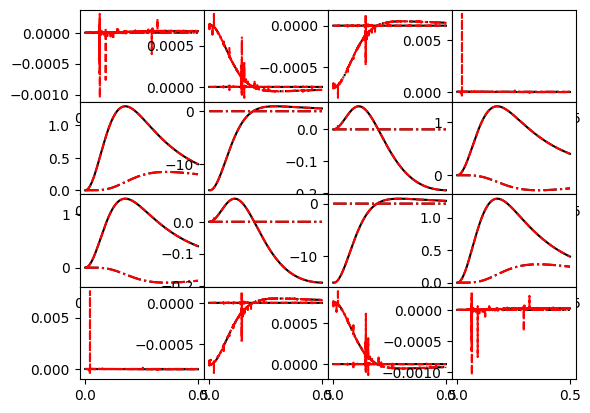

In [8]:
plot_kappa(0.0001)


In [9]:
plot_kappa(0.00005)
